In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:

import numpy as np
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image


In [4]:
def normalize_image(img):
    img = 255*(img+1.0)/2.0
    return tf.cast(img,tf.uint8)

In [5]:
import matplotlib.pyplot as plt
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [6]:
#save image
def save_image(img,file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

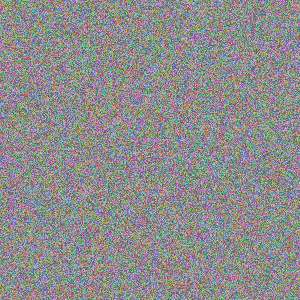

In [7]:
img_noise = np.random.uniform(size=(300,300,3)) + 100.0
img_noise = img_noise.astype(np.float32)
show_image(normalize_image(img_noise))


In [8]:
base_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [9]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [10]:
layer_names = 'mixed4'
layers = base_model.get_layer(layer_names).output

In [11]:
dream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)

In [12]:
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [13]:
def calc_loss(img,model):
    channel=139#choose channel
    img=tf.expand_dims(img,axis=0)
    layer_activations = model(img)

    act = layer_activations[:,:,:,channel]
    loss = tf.math.reduce_mean(act)#The outputs of the selected channels are averaged
    return loss

In [14]:
def render_deepdream(model,img,steps=100,step_size=0.8,verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            #Gradient transformation
            tape.watch(img)
            loss = calc_loss(img,model)
        #Calculating the loss
        gradients = tape.gradient(loss,img)
        gradients /= tf.math.reduce_std(gradients) +1e-8


        img = img+gradients*step_size
        img = tf.clip_by_value(img,-1,1)

        #output infomation
        if(verbose ==1):
            if((n+1)%10==0):
                print("Step {}/{},loss {}".format(n+1,steps,loss))
    return img

In [15]:
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

START...
Step 10/100,loss 5.120166778564453
Step 20/100,loss 13.311005592346191
Step 30/100,loss 17.46986961364746
Step 40/100,loss 20.04053497314453
Step 50/100,loss 22.01247787475586
Step 60/100,loss 23.501602172851562
Step 70/100,loss 24.79545021057129
Step 80/100,loss 25.70549774169922
Step 90/100,loss 26.591468811035156
Step 100/100,loss 27.260528564453125
DREAM....


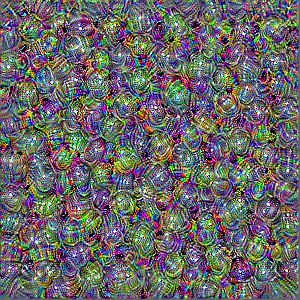

SAVE：


In [16]:
import time

start = time.time()
print("START...")

#optimization procedure
dream_img = render_deepdream(dream_model,img,steps=100,step_size=0.05)

end = time.time()
end-start
print("DREAM....")

dream_img = normalize_image(dream_img)
show_image(dream_img)

#save
file_name = 'deepdream_{}.jpg'.format(layer_names)
save_image(dream_img,file_name)
print("SAVE：".format(file_name))